In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
LATENT_DIM = 512
IMAGE_SIZE = 32
BATCH_SIZE = 16
EPOCHS = 5


In [3]:
def mapping_network(latent_dim, layers=8):
    model = tf.keras.Sequential(name="MappingNetwork")
    for _ in range(layers):
        model.add(tf.keras.layers.Dense(latent_dim, activation='relu'))
    return model

mapping_net = mapping_network(LATENT_DIM)


In [4]:
class AdaIN(tf.keras.layers.Layer):
    def call(self, inputs):
        content, style = inputs
        mean, variance = tf.nn.moments(content, axes=[1, 2], keepdims=True)
        normalized = (content - mean) / tf.sqrt(variance + 1e-8)
        scale, bias = style
        return scale * normalized + bias


In [5]:
def progressive_block(x, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x


In [6]:
def build_generator():
    noise = tf.keras.Input(shape=(LATENT_DIM,))
    style = mapping_net(noise)

    x = tf.keras.layers.Dense(4 * 4 * 128)(style)
    x = tf.keras.layers.Reshape((4, 4, 128))(x)

    x = progressive_block(x, 128)  # 8x8
    x = progressive_block(x, 64)   # 16x16
    x = progressive_block(x, 32)   # 32x32

    output = tf.keras.layers.Conv2D(3, 1, activation="sigmoid")(x)
    return tf.keras.Model(noise, output)

generator = build_generator()
generator.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 MappingNetwork (Sequential  (None, 512)               2101248   
 )                                                               
                                                                 
 dense_8 (Dense)             (None, 2048)              1050624   
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 128)         147584    
                                                                 
 up_sampling2d (UpSampling2  (None, 8, 8, 128)         0         
 D)                                                          

In [7]:
def build_discriminator():
    img = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = tf.keras.layers.Conv2D(64, 3, strides=2, activation="relu")(img)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    output = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(img, output)

discriminator = build_discriminator()
discriminator.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 15, 15, 64)        1792      
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 81921 (320.00 KB)
Trainable params: 81921 (320.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam(1e-4)
d_optimizer = tf.keras.optimizers.Adam(1e-4)


In [9]:
def get_dataset():
    images = np.random.rand(200, IMAGE_SIZE, IMAGE_SIZE, 3).astype("float32")
    return tf.data.Dataset.from_tensor_slices(images).shuffle(100).batch(BATCH_SIZE)

dataset = get_dataset()


In [10]:
@tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)

        g_loss = loss_fn(tf.ones_like(fake_output), fake_output)
        d_loss = loss_fn(tf.ones_like(real_output), real_output) + \
                 loss_fn(tf.zeros_like(fake_output), fake_output)

    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    return g_loss, d_loss


In [11]:
for epoch in range(EPOCHS):
    for real_images in dataset:
        g_loss, d_loss = train_step(real_images)
    print(f"Epoch {epoch+1}: G={g_loss:.4f}, D={d_loss:.4f}")


Epoch 1: G=0.6873, D=1.3632
Epoch 2: G=0.6266, D=1.3971
Epoch 3: G=0.5291, D=1.5149
Epoch 4: G=0.6092, D=1.4714
Epoch 5: G=0.6410, D=1.2700


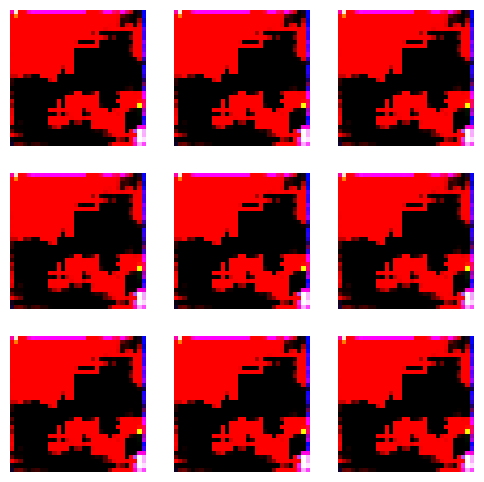

In [12]:
def visualize_images(images, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(6, 6))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(images[i])
        ax.axis("off")
    plt.show()

noise = tf.random.normal([9, LATENT_DIM])
generated = generator(noise)
visualize_images(generated, 3, 3)
